In [1]:
%matplotlib inline
from pprint import pprint

from plot import plot_two
from simulate import simulate_withdrawals
from harvesting import N_60_RebalanceHarvesting


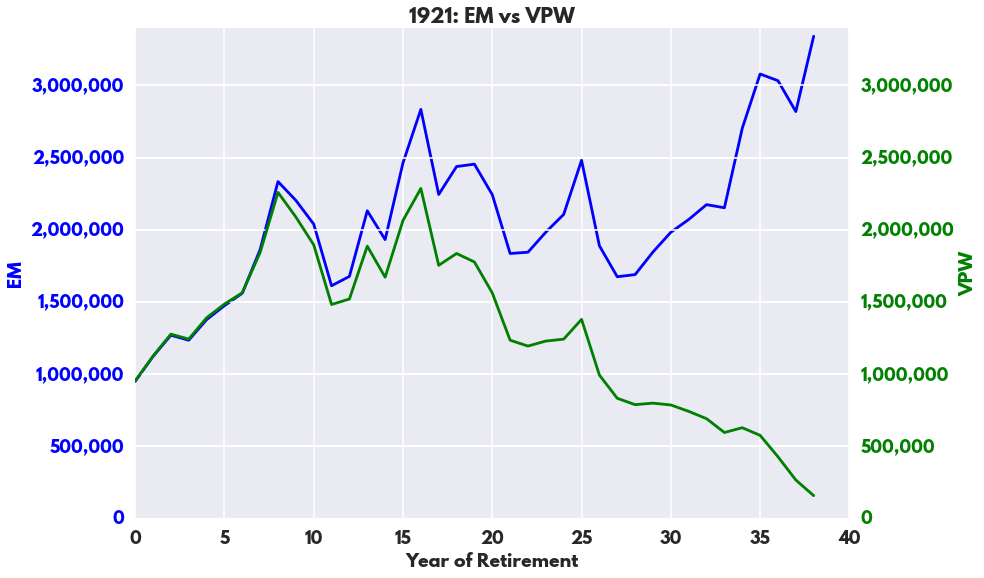

In [2]:
import math
from market import Returns_US_1871
from withdrawal import VPW

def compare_em_vs_vpw(series, years=40, title=''):
    (r1, r2) = itertools.tee(series)
    x = simulate_withdrawals(r1, years=years, harvesting=N_60_RebalanceHarvesting)
    y = simulate_withdrawals(r2, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=VPW)

    s1 = [n.portfolio_r for n in x]
    s2 = [n.portfolio_r for n in y]

    ceiling = max(max(s1), max(s2))
    if ceiling < 100000:
        ceiling = int(math.ceil(ceiling / 10000) * 10000)
    else:
        ceiling = int(math.ceil(ceiling / 100000) * 100000)
    
    plot_two(s1, s2, s1_title='EM', s2_title='VPW',
                       y_lim=[0,ceiling],
                       x_label='Year of Retirement', title=title)

def em_vs_vpw(year, years=40):
    compare_em_vs_vpw(Returns_US_1871().iter_from(year), title='%d: EM vs VPW' % year, years=years)

# TODO: VPW gets a divide by zero error when I use 40 years...
em_vs_vpw(1921, years=39)

In [3]:
def em_wer(us):
    lifespan = gen_age() - 65
    
    portfolio = starting_portfolio = Decimal('100')
    withdrawals = []
    returns = []
    
    em = EM.calc_withdrawal(portfolio, 40, cap_rate=Decimal('3'))
    wd = em.send(None)
    withdrawals.append(wd / portfolio)
    portfolio -= wd
    
    for i in range(lifespan):
        r = us.random_year()
        gain = (r.stocks / 5 * 3) + (r.bonds / 5 * 2)
        returns.append(gain)
        
        portfolio *= (1 + gain)
    
        wd = em.send((portfolio, r.inflation))
        withdrawals.append(wd / starting_portfolio)
        portfolio -= wd

    return wer(withdrawals, returns)

def const_pct_wer(us, constant=Decimal('.055')):
    lifespan = gen_age() - 65
    
    portfolio = starting_portfolio = Decimal('100')
    returns = []
    withdrawals = []
    
    c = True
    while c:
        # start of year withdraw stuff
        wd = constant * portfolio
        portfolio -= wd
        withdrawals.append(wd / starting_portfolio)

        # end of year, receive gains
        r = us.random_year()
        gain = (r.stocks / 5 * 3) + (r.bonds / 5 * 2)
        portfolio *= (1 + gain)
        returns.append(gain)
        
        c = (lifespan > 0)
        lifespan -= 1

    return wer(withdrawals, returns)

def vpw_wer(us):
    lifespan = gen_age() - 65
        
    portfolio = starting_portfolio = Decimal('100')
    wd = vpw_rates[0] * portfolio
    withdrawals = [wd / starting_portfolio]
    portfolio -= wd
    
    returns = []

    for i in range(lifespan):
        r = us.random_year()
        gain = (r.stocks / 5 * 3) + (r.bonds / 5 * 2)
        returns.append(gain)

        portfolio *= (1 + gain)

        wd = vpw_rates[i+1] * portfolio
        withdrawals.append(wd / starting_portfolio)
        portfolio -= wd

    return wer(withdrawals, returns)

def calc_wer(n, fn_wer, returns):
    w = []
    for i in range(n):
        w.append(fn_wer(returns))
    return numpy.average([float(n) for n in w])

pprint(calc_wer(100, vpw_wer, conservative[60]))
print(calc_wer(100, const_pct_wer, conservative[60]))
print(calc_wer(100, em_wer, conservative[60]))

0.50617008489833426
0.534238056757
0.523340284895


In [5]:
from matplotlib import pyplot as plt
import matplotlib
import plot

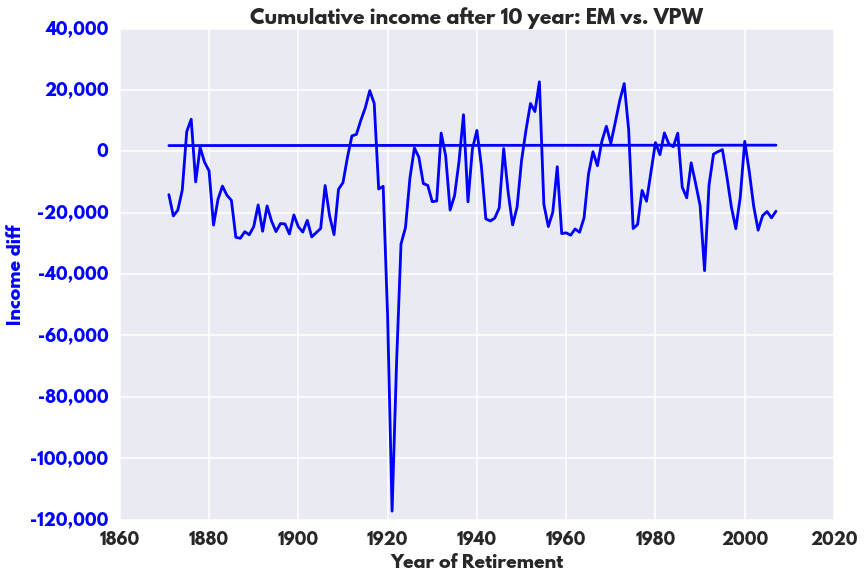

In [6]:
data_series = Returns_US_1871()

income_diff = []

YEARS = 10
for i in range(data_series.years_of_data):
    year = i + 1871

    (s1, s2) = itertools.tee(data_series.iter_from(year))
    x = simulate_withdrawals(s1, years=YEARS, harvesting=N_60_RebalanceHarvesting)
    y = simulate_withdrawals(s2, years=YEARS, harvesting=N_60_RebalanceHarvesting, withdraw=VPW)

    # skip incomplete retirements
    if len(x) < YEARS:
        continue

    em_income = sum([n.withdraw_r for n in x])
    vpw_income = sum([n.withdraw_r for n in y])
    income_diff.append((em_income - vpw_income, year))

x_values = range(1871, 1871 + len(income_diff))

#ylim = [-100000, 50000]

#pprint(sorted(income_diff))

fig, ax1 = plt.subplots()
plot.format_axis_labels_with_commas(ax1.get_yaxis())
ax1.plot(x_values, income_diff, 'b')
#ax1.set_ylim(ylim)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylabel('Income diff', color='b')
ax1.set_xlabel('Year of Retirement')

#ax2 = ax1.twinx()
#common.format_axis_labels_with_commas(ax2.get_yaxis())
#ax2.plot(x_values, portfolio_diff, 'g')
#ax2.set_ylim(ylim)
#for tl in ax2.get_yticklabels():
#    tl.set_color('g')
#ax2.set_ylabel('Portfolio diff', color='g')

plt.title('Cumulative income after %d year: EM vs. VPW' % YEARS)

plt.show()

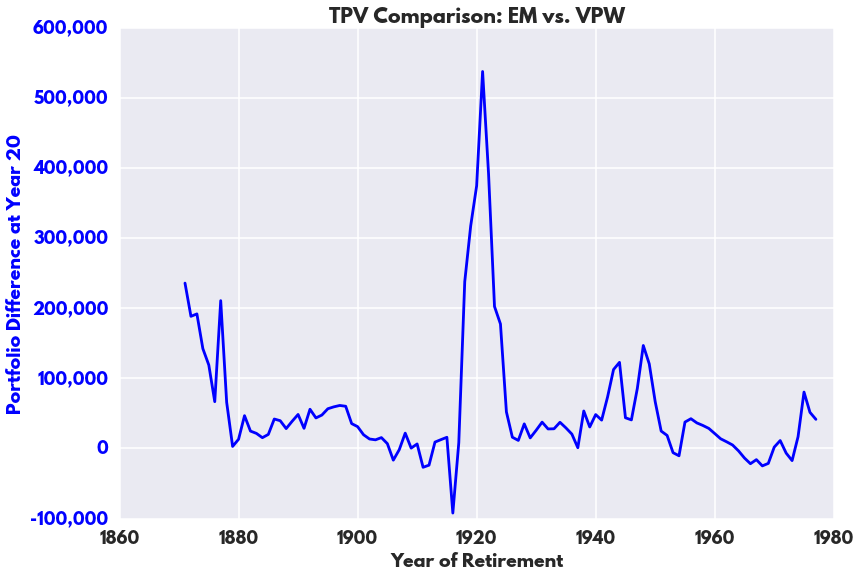

In [9]:
from plot import format_axis_labels_with_commas

data_series = Returns_US_1871()

tpv_diff = []
YEARS = 40
for i in range(data_series.years_of_data):
    year = i + 1871

    (s1, s2) = itertools.tee(data_series.iter_from(year))
    x = simulate_withdrawals(s1, years=YEARS)
    y = simulate_withdrawals(s2, years=YEARS, withdraw=VPW)

    # skip incomplete retirements
    if len(x) < 40:
        continue

    tpv_diff.append(x[19].portfolio_r - y[19].portfolio_r)

x_values = range(1871, 1871 + len(tpv_diff))

fig, ax1 = plt.subplots()
format_axis_labels_with_commas(ax1.get_yaxis())
ax1.plot(x_values, tpv_diff, 'b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylabel('Portfolio Difference at Year 20', color='b')
ax1.set_xlabel('Year of Retirement')

plt.title('TPV Comparison: EM vs. VPW')

plt.show()